In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
from tumor_models import (
    Searcher,
    Solver,
    LinearGrowthModel,
    ExponentialGrowthModel,
    MendelsohnGrowthModel,
    ExponentialSaturatingModel,
    LogisticGrowthModel,
    MontrollGrowthModel,
    VonBertalanffyModel,
    GompertzLesModel,
    GompertzPaperModel,
    SurfaceLimitedModel,
    AlleeModel,
    LinearLimitedModel,
)



plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True


In [12]:
# Data 1
ts1 = np.array([0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120], dtype=float)
Vs1 = np.array([250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000], dtype=float)

# Data 2
ts2 = np.array([
     3.46,  4.58,  5.67,  6.64,  7.63,  8.41,  9.32, 10.27, 11.19,
    12.39, 13.42, 15.19, 16.24, 17.23, 18.18, 19.29, 21.23, 21.99,
    24.33, 25.58, 26.43, 27.44, 28.43, 30.49, 31.34, 32.34, 33.00,
    35.20, 36.34, 37.29, 38.50, 39.67, 41.37, 42.58, 45.39, 46.38,
    48.29, 49.24, 50.19, 51.14, 52.10, 54.00, 56.33, 57.33, 59.38,
], dtype=float)

Vs2 = np.array([
    0.0158, 0.0264, 0.0326, 0.0445, 0.0646, 0.0933, 0.1454, 0.2183, 0.2842,
    0.4977, 0.6033, 0.8441, 1.2163, 1.4470, 2.3298, 2.5342, 3.0064, 3.4044,
    3.2046, 4.5241, 4.3459, 5.1374, 5.5376, 4.8946, 5.0660, 6.1494, 6.8548,
    5.9668, 6.6945, 6.6395, 6.8971, 7.2966, 7.2268, 6.8815, 8.0993, 7.2112,
    7.0694, 7.4971, 6.9974, 6.7219, 7.0523, 7.1095, 7.0694, 8.0562, 7.2268, 
], dtype=float)


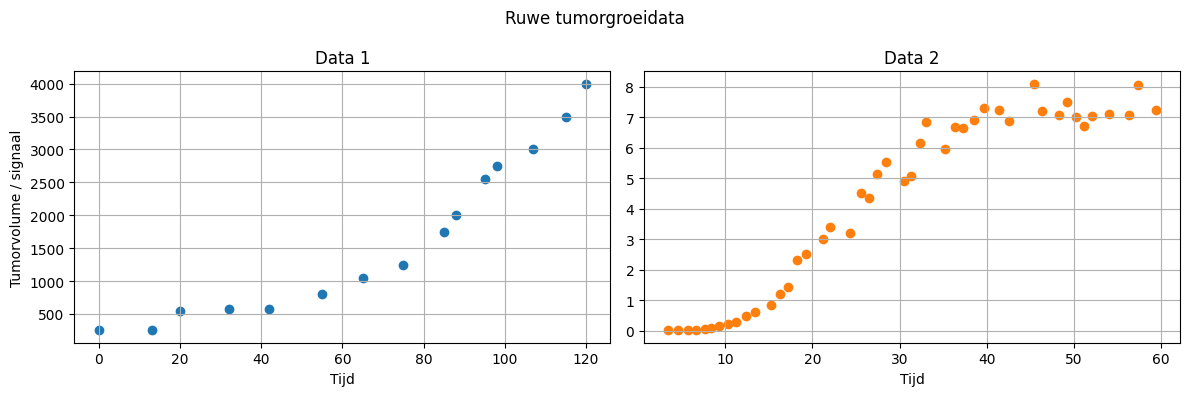

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].scatter(ts1, Vs1, color="tab:blue")
axes[0].set_title("Data 1")
axes[0].set_xlabel("Tijd")
axes[0].set_ylabel("Tumorvolume / signaal")

axes[1].scatter(ts2, Vs2, color="tab:orange")
axes[1].set_title("Data 2")
axes[1].set_xlabel("Tijd")

plt.suptitle("Ruwe tumorgroeidata")
plt.tight_layout()
plt.show()


In [14]:
def get_param_bounds(model_name, V):
    """
    Geef (min, max) grenzen per parameter op basis van de data.
    V is de vector met gemeten volumes/waarden.
    """
    Vmax = float(max(V))
    Vmin = float(min(V))

    # kleine buffer tegen exact 0
    if Vmin <= 0:
        Vmin = Vmax * 0.001

    if model_name == "Lineair":
        # dV/dt = c
        return [(0.0, 100.0)]  # c

    elif model_name == "Exponentieel":
        # dV/dt = c * V
        return [(0.0, 0.5)]  # c

    elif model_name == "Mendelsohn":
        # dV/dt = c * V^d
        return [(0.0, 1.0), (0.0, 3.0)]  # c, d

    elif model_name == "Exp-afvlakkend":
        # dV/dt = c * (Vmax - V)
        return [(0.0, 1.0), (Vmax * 0.5, Vmax * 3.0)]  # c, Vmax (asymptote)

    elif model_name == "Logistisch":
        # dV/dt = c * V * (Vmax - V)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 3.0)]  # c, Vmax

    elif model_name == "Montroll":
        # dV/dt = c * V * (Vmax^d - V^d)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 3.0), (0.5, 3.0)]  # c, Vmax, d

    elif model_name == "Von Bertalanffy":
        # dV/dt = c * V^(2/3) - d * V
        return [(0.0, 1.0), (0.0, 1.0)]  # c, d

    elif model_name == "Gompertz-les":
        # dV/dt = c * V * ln(cap / V)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 5.0)]  # c, cap

    elif model_name == "Gompertz-paper":
        # dV/dt = alpha * exp(-beta * t) * V
        return [(0.0, 1.0), (0.0, 0.5)]  # alpha, beta

    elif model_name == "Oppervlakte-gelimiteerd":
        # dV/dt = c * V / (V + d)^(1/3)
        return [(0.0, 1.0), (1.0, Vmax * 2.0)]  # c, d

    elif model_name == "Allee":
        # dV/dt = c * (V - Vmin) * (Vmax - V)
        return [
            (0.0, 0.5),             # c
            (0.0, Vmax * 0.7),      # Vmin
            (Vmax * 0.7, Vmax * 2)  # Vmax (Allee-Vmax)
        ]

    elif model_name == "Lineair-gelimiteerd":
        # dV/dt = c * V / (V + d)
        return [(0.0, 1.0), (1.0, Vmax * 2.0)]  # c, d

    else:
        raise ValueError(f"Onbekend model: {model_name}")



In [15]:
def bounded_random_search(bounds, searcher, iters=2000, sigma=0.1):
    """
    Eenvoudige hill-climbing random search binnen gegeven grenzen.

    bounds : list van (min, max) per parameter
    searcher : jouw Searcher-instance
    """
    import random

    # start met random parameters binnen [min, max]
    params = [
        random.uniform(low, high)
        for (low, high) in bounds
    ]
    best_error = searcher.mean_squared_error(*params)

    for _ in range(iters):
        # voorstel nieuwe parameters (kleine Gauss-stap, binnen de grenzen clamped)
        candidate = []
        for (p, (low, high)) in zip(params, bounds):
            new_p = p + gauss(0.0, sigma)
            new_p = max(low, min(high, new_p))
            candidate.append(new_p)

        err = searcher.mean_squared_error(*candidate)
        if err < best_error:
            best_error = err
            params = candidate

    return params, best_error

In [16]:
def fit_model_on_data(model_class, model_name, n_params, t, V, method="runge-kutta"):
    searcher = Searcher(
        real_vals=V,
        time_values=t,
        n_params=n_params,
        model=model_class,
        predict_function=method,
    )

    # 1) Parameterruimte op basis van data
    bounds = get_param_bounds(model_name, V)

    # 2) Zoeken binnen die grenzen
    param_list, mse = bounded_random_search(bounds, searcher)

    # Als MSE al inf is → model is gewoon slecht/numeriek instabiel
    if not np.isfinite(mse):
        t_smooth = np.linspace(float(t.min()), float(t.max()), 100)
        V_smooth = np.full_like(t_smooth, np.nan)
        param_dict = {i: p for i, p in enumerate(param_list)}
        return {
            "params": param_dict,
            "mse": float("inf"),
            "t_smooth": t_smooth,
            "V_smooth": V_smooth,
        }

    # 3) Gladde curve maken met Solver + Runge–Kutta
    t_min, t_max = float(t.min()), float(t.max())
    total_time = t_max - t_min

    try:
        solver = Solver(
            1000,              # n_steps
            total_time,        # time
            model_class,       # model
            float(V[0]),       # init_volume
            t_min,             # init_time
            *param_list        # modelparameters
        )
        t_smooth, V_smooth = solver.runge_kutta_function()

    except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
        # Als het alsnog misgaat → markeer model als zeer slecht
        t_smooth = np.linspace(t_min, t_max, 100)
        V_smooth = np.full_like(t_smooth, np.nan)
        mse = float("inf")

    param_dict = {i: p for i, p in enumerate(param_list)}

    return {
        "params": param_dict,
        "mse": mse,
        "t_smooth": np.array(t_smooth),
        "V_smooth": np.array(V_smooth),
    }


In [17]:
def compare_models_on_dataset(models_info, t, V, title="Modelvergelijking"):
    """
    models_info: lijst van (model_class, n_params, naam)
    """
    results = []
    curves = {}

    for model_class, n_params, name in models_info:
        print(f"Fitten van model: {name}")
        res = fit_model_on_data(model_class, name, n_params, t, V)
        results.append({
            "model": name,
            "n_params": n_params,
            "MSE": res["mse"],
            "params": res["params"],
        })
        curves[name] = res

    df = pd.DataFrame(results).sort_values("MSE").reset_index(drop=True)

    print("\nSamenvatting (gesorteerd op MSE):")
    display(df[["model", "n_params", "MSE"]])

    best_row = df.iloc[0]
    best_name = best_row["model"]
    best_params = best_row["params"]

    print(f"\nBeste model volgens MSE: {best_name}")
    print("Geschatte parameters (index → waarde):", best_params)

    # Visualisatie
    plt.figure(figsize=(7, 4))
    plt.scatter(t, V, color="k", label="Data")

    for name, res in curves.items():
        plt.plot(res["t_smooth"], res["V_smooth"], label=name)

    plt.title(title + f" (beste: {best_name})")
    plt.xlabel("Tijd")
    plt.ylabel("Tumorvolume / signaal")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df, best_name, best_params, curves


In [18]:
models_to_try = [
    (LinearGrowthModel,          1, "Lineair"),
    (ExponentialGrowthModel,     1, "Exponentieel"),
    (MendelsohnGrowthModel,      2, "Mendelsohn"),
    (ExponentialSaturatingModel, 2, "Exp-afvlakkend"),
    (LogisticGrowthModel,        2, "Logistisch"),
    (MontrollGrowthModel,        3, "Montroll"),
    (VonBertalanffyModel,        2, "Von Bertalanffy"),
    (GompertzLesModel,           2, "Gompertz-les"),
    (GompertzPaperModel,         2, "Gompertz-paper"),
    (SurfaceLimitedModel,        2, "Oppervlakte-gelimiteerd"),
    (AlleeModel,                 3, "Allee"),
    (LinearLimitedModel,         2, "Lineair-gelimiteerd"),
]



Fitten van model: Lineair
Fitten van model: Exponentieel
Fitten van model: Mendelsohn
Fitten van model: Exp-afvlakkend
Fitten van model: Logistisch


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:79: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * V * (self.Vmax - V)
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/Searcher.py:67: RuntimeWarning: overflow encountered in scalar multiply
  sum_squared_error += error * error
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/Solver.py:118: RuntimeWarning: overflow encountered in scalar multiply
  V3 = V + k3 * self.dt
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/Solver.py:123: RuntimeWarning: overflow encountered in scalar multiply
  V = V + (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0 * self.dt


Fitten van model: Montroll


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:93: RuntimeWarning: invalid value encountered in scalar power
  return self.c * V * (self.Vmax**self.d - V**self.d)


Fitten van model: Von Bertalanffy


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:100: RuntimeWarning: invalid value encountered in scalar power
  return self.c * (V ** (2/3)) - self.d * V


Fitten van model: Gompertz-les
Fitten van model: Gompertz-paper
Fitten van model: Oppervlakte-gelimiteerd
Fitten van model: Allee


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:144: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * (V - self.Vmin) * (self.Vmax - V)


Fitten van model: Lineair-gelimiteerd

Samenvatting (gesorteerd op MSE):


,model,n_params,MSE
0,Mendelsohn,2,1.212887e+04
1,Gompertz-paper,2,2.431188e+04
2,Gompertz-les,2,4.859500e+04
3,Oppervlakte-gelimiteerd,2,5.984947e+04
4,Exponentieel,1,7.994458e+04
5,Lineair,1,1.399632e+05
6,Exp-afvlakkend,2,1.923571e+05
7,Lineair-gelimiteerd,2,3.410793e+06
8,Logistisch,2,3.418962e+06
9,Allee,3,3.418962e+06



Beste model volgens MSE: Mendelsohn
Geschatte parameters (index → waarde): {0: 0.31540939674770785, 1: 0.646853806718664}


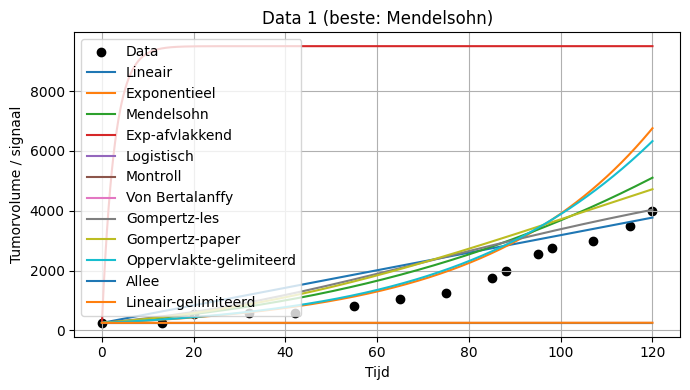

In [19]:
df1, best_name1, best_params1, curves1 = compare_models_on_dataset(
    models_info=models_to_try,
    t=ts1,
    V=Vs1,
    title="Data 1"
)


Fitten van model: Lineair
Fitten van model: Exponentieel
Fitten van model: Mendelsohn
Fitten van model: Exp-afvlakkend
Fitten van model: Logistisch
Fitten van model: Montroll


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:93: RuntimeWarning: invalid value encountered in scalar power
  return self.c * V * (self.Vmax**self.d - V**self.d)


Fitten van model: Von Bertalanffy
Fitten van model: Gompertz-les
Fitten van model: Gompertz-paper
Fitten van model: Oppervlakte-gelimiteerd
Fitten van model: Allee


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:144: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * (V - self.Vmin) * (self.Vmax - V)
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/Searcher.py:67: RuntimeWarning: overflow encountered in scalar multiply
  sum_squared_error += error * error
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/Solver.py:123: RuntimeWarning: overflow encountered in scalar multiply
  V = V + (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0 * self.dt


Fitten van model: Lineair-gelimiteerd

Samenvatting (gesorteerd op MSE):


,model,n_params,MSE
0,Gompertz-paper,2,1.833583e-01
1,Logistisch,2,1.953322e-01
2,Von Bertalanffy,2,3.694121e-01
3,Exp-afvlakkend,2,8.134033e-01
4,Mendelsohn,2,8.205752e-01
5,Lineair-gelimiteerd,2,2.009554e+00
6,Gompertz-les,2,4.623879e+00
7,Montroll,3,7.424340e+00
8,Oppervlakte-gelimiteerd,2,1.074915e+01
9,Exponentieel,1,1.185382e+01



Beste model volgens MSE: Gompertz-paper
Geschatte parameters (index → waarde): {0: 0.8243208618710837, 1: 0.09538467554203803}


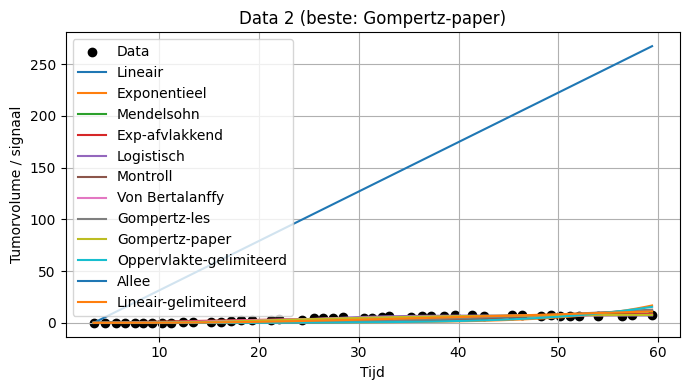

In [20]:
df2, best_name2, best_params2, curves2 = compare_models_on_dataset(
    models_info=models_to_try,
    t=ts2,
    V=Vs2,
    title="Data 2"
)
